## Analisando caracteristicas da série temporal

Assim como em qualquer análise de dados, é interessante obter um sumário estatístico básico da série temporal, o que inclui a média, o mínimo, o máximo, entre outras medidas. Estes podem ser calculados usando o método `describe()`.

In [1]:
# Importar bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# carregar dados
rend = pd.read_excel('dados/rendimentos_pnadc.xlsx')
# Ajustar variável de tempo
rend['data'] = pd.to_datetime(rend['data'], format='%Y-%m').dt.strftime('%Y-%m')
# Indexar
rend = rend.set_index('data')
print(rend.info())
rend.head()

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 2012-03 to 2022-02
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   rendimento médio (R$)  120 non-null    int64
dtypes: int64(1)
memory usage: 1.9+ KB
None


,rendimento médio (R$)
data,
2012-03,1500
2012-04,1420
2012-05,1424
2012-06,1433
2012-07,1445


In [8]:
# carregar dados de ipca
ipca = pd.read_excel('dados/ipca.xlsx')
# Converter variavel de período para 'datatime'
ipca['periodo'] = pd.to_datetime(ipca['periodo'], format='%Y-%m').dt.strftime('%Y-%m')
# Definir informação de tempo como indice do DF
ipca = ipca.set_index('periodo')
# Filtar período
ipca = ipca["2012-03" : "2022-02"]
# Alterar base
ipca_atual = ipca.iloc[ipca.shape[0]-1] / ipca
ipca_atual.info()
ipca_atual.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 2012-03 to 2022-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ipca    120 non-null    float64
dtypes: float64(1)
memory usage: 1.9+ KB


,ipca
periodo,
2021-10,1.032687
2021-11,1.022969
2021-12,1.015555
2022-01,1.010101
2022-02,1.000000


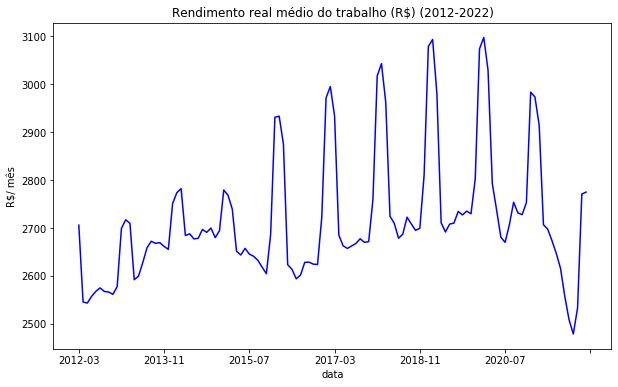

In [11]:
# Calcular rendimento real
rend['rendimento real médio (R$)'] = rend['rendimento médio (R$)'] * ipca_atual['ipca']

# Plotar dos dados de rendimento real
fig, ax = plt.subplots(figsize=(10,6))
ax = rend['rendimento real médio (R$)'].plot(color='blue')
# Especificar título para o eixo y (PIB)
ax.set_title('Rendimento real médio do trabalho (R$) (2012-2022)')
# Especificar um tótulo para o eixo x
ax.set_xlabel('data')
# Especificar um tótulo para o eixo y (PIB)
ax.set_ylabel('R$/ mês')
# Mostrar gráfico
plt.show()

In [12]:
# Sumário estatístico com o método 'describe'
rend['rendimento real médio (R$)'].describe()

count     120.000000
mean     2720.243680
std       133.490327
min      2478.652881
25%      2644.934272
50%      2691.303794
75%      2751.418865
max      3097.880979
Name: rendimento real médio (R$), dtype: float64

Na análise do grafico percebemos um forte comportamento sazonal desta série. Ao longo da análise vamos lidar melhor com esta característica.

## Autocorrelação

O coeficiente de correlação entre dois valores numa série temporal é dado pela **função de autocorrelação (FAC ou ACF - autocorrelation function)**. O FAC é uma maneira de medir a relação linear entre uma observação no tempo $t$ e as observações nos tempos anteriores.

A autocorrelação de defasagem $k$ é a correlação entre valores que estão separados por $k$ períodos de tempo. Assim, a autocorrelação de defasagem 1 (ou seja, k = 1) é a correlação entre valores que estão separados por um período de tempo.

A princípio, a correlação entre $y_t$ e $y_{t-k}$ é:

$$
\rho_k =\frac{E\left[\left(y_t - \mu\right)\left(y_{t-k} - \mu\right)\right]}{\sigma_{y_t} \sigma_{y_{t-k}}}
$$


### Função de autocorrelação parcial
Outra medida de interesse é a associação entre $y_t$ e $y_{t-k}$ "livre" da influência linear de valores intermediários, ou seja, "livre" dos efeitos de $y_{t-1}, y_{t-2}, \cdots, y_{t-k-1}$, o que requer uma transformação na série temporal. Para esse caso, calcula-se a função de **autocorrelação parcial (FACP ou PACF - partial autocorrelation function)** sobre a série temporal transformada.

Em um modelo autoregressivo, a FACP é mais útil para identificar a ordem do modelo. Especificamente, autocorrelações parciais de amostra que são significativamente diferentes de 0 indicam termos defasados de $y$ que são efetivamente úteis como preditores de $y_t$.

### statsmodels.tsa

O `statsmodels.tsa` contém diversas classes e funções úteis para análise de séries temporais.

O `stattools` que pertence ao `statsmodels.tsa` possui diversas funções para calculo de estatísticas e realização de testes como a FAC(acf) e a FACP (pacf), teste de raiz unitária, testes de causalidade de Granger, entre outros.

Aqui vamos usar a função `statsmodels.tsa.stattools.acf` para estimar a FAC

In [21]:
# Import the acf module and the plot_acf module from statsmodels
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

In [22]:
# Compute the acf array of HRB
acf, ci_acf = acf(rend['rendimento real médio (R$)'], alpha=.05)

C:\Users\vitor\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


In [26]:
print(type(acf))
print(type(ci_acf))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [27]:
np.column_stack((acf,ci_acf))

array([[ 1.        ,  1.        ,  1.        ],
       [ 0.76311939,  0.58419998,  0.9420388 ],
       [ 0.37893286,  0.11569002,  0.6421757 ],
       [ 0.05663089, -0.22352987,  0.33679165],
       [-0.04420418, -0.32473115,  0.23632279],
       [-0.05890163, -0.33965149,  0.22184823],
       [-0.07568344, -0.35682861,  0.20546174],
       [-0.10507644, -0.38687308,  0.17672019],
       [-0.13904475, -0.42209287,  0.14400337],
       [-0.08942662, -0.37465293,  0.19579969],
       [ 0.19026995, -0.0958525 ,  0.4763924 ],
       [ 0.53395574,  0.24381111,  0.82410038],
       [ 0.74645453,  0.42639548,  1.06651359],
       [ 0.55205501,  0.18042107,  0.92368895],
       [ 0.22820013, -0.16881894,  0.6252192 ],
       [-0.04299895, -0.44419495,  0.35819704],
       [-0.13108526, -0.53242876,  0.27025823],
       [-0.14769546, -0.55040721,  0.25501629],
       [-0.17019929, -0.57464134,  0.23424276],
       [-0.19770052, -0.60442896,  0.20902791],
       [-0.22904742, -0.63884059,  0.180

A análise de gráficos da FAC são muito úteis na análise de séries temporais univariadas.

Vamos plotar o gráfico da FAC usando a função `plot_acf` do `statsmodels.graphics.tsaplots`.

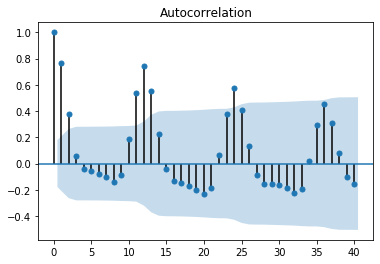

In [29]:
# Plot the acf function
plot_acf(rend['rendimento real médio (R$)'], lags=40, alpha=.05)
plt.show()

Temos nesse gráfico um conjunto de barras e uma área, que lembra um cone, com fundo azul. Este cone representa um intervalo de confiança (aqui definimos o nível de confiança de 95%, com o argumento 'alpha=.05'). Se o ponto de cada barra está fora do cone (na área branca), podemos dizer que, com 95% de probabilidade, o valor $y_{t-k}$ está correlacionado com $y_t$. Se a barra estiver dentro do cone (na área em azul), você pode ignorar esse valor defasado específico, pois provavelmente não é relevante.

Neste exemplo, as duas primeiras defasagens são relevates, depois temos como relevantes a 11ª, 12ª, 13ª e 24ª.
Isso reflete o forte carater sazonal da série em questão, que fica muito evidente neste gráfico.